> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# Multivariate Input - Multivariate Output -Single-Step
This tutorial is to demonstrate the process in build LSTM for the Multivariate Input - Multivariate Output -Single-Step ,Single Step.

The Demostration of Building LSTM using Synthetic data. First, we will show the step in building the LSTM :

Step 1. Data Preparation (Data Splitting,Data Sequencing,Data Normalization and Batching the Data)<br>
Step 2. Model Configuration (Vanila LSTM , Stacked LSTM , Bidirectional LSTM)<br>
Step 3. Train the model<br>
Step 4. Validate the model using graph<br>
Step 5. Evaluation Metrics such as MSE<br>
Step 6. Plot the forecast result<br>

First , let's us import the package needed

In [1]:
# import libary need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import math

In [2]:
def multivariate_multivariate_single_step(sequence,window_size):
    x, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + window_size
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix,:], sequence[end_ix,:]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)


## Hyperparameter
Define the hyper parameter that need to tune the model

In [3]:
split_ratio = 0.70
num_epochs = 300
window_size = 4
n_step = 1
learning_rate = 0.01
#seed
torch.manual_seed(123)

## Data Preparation
We create synthetic data to make sure the model is created correctly and having ability to perform the forecasting

In [4]:
in_seq1 = np.array([x for x in range(0, 300, 10)])
in_seq2 = np.array([x for x in range(5, 305, 10)])
out_seq = np.array([in_seq1[i] + in_seq2[i] for i in range(len(in_seq1))])


# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))

# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

## Visualize the synthetic data

<AxesSubplot:>

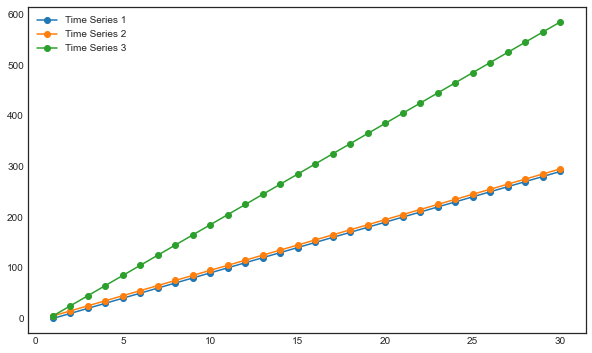

In [5]:
dataset_plot=pd.DataFrame(dataset,columns=["Time Series 1","Time Series 2","Time Series 3"],index=range(1,len(dataset)+1))
dataset_plot.plot(marker='o', figsize=(10,6))

## Data Splitting

In [6]:
split_data = round(len(dataset)*split_ratio)
split_data

21

In [7]:
#split data by indexing 
train_data = dataset[:split_data]
test_data = dataset[split_data:]
print("train_data_shape")
print(train_data.shape)
print("test_data_shape")
print(test_data.shape)

train_data_shape
(21, 3)
test_data_shape
(9, 3)


## Data Standardlization
The data is scaled to mean = 0 , variance = 1

In [8]:
scaler = StandardScaler().fit(train_data.reshape(-1, 1))
train_data_standardize = scaler.transform(train_data.reshape(-1, 1))
test_data_standardize  = scaler.transform(test_data.reshape(-1, 1))

In [9]:
#transform after scaling
train_data_standardize = train_data_standardize .reshape(train_data.shape[0],train_data.shape[1])
print("test_data_normalized"+str(train_data_standardize.shape))

test_data_standardize = test_data_standardize.reshape(test_data.shape[0],test_data.shape[1])
print("test_data_normalized"+str(test_data_standardize.shape))

test_data_normalized(21, 3)
test_data_normalized(9, 3)


## Data Seqeuncing

In [10]:
trainX ,trainY =  multivariate_multivariate_single_step(train_data_standardize,window_size)
testX , testY = multivariate_multivariate_single_step(test_data_normalized,window_size)
print(f"trainX shape:{trainX.shape} trainY shape:{trainY.shape}\n")
print(f"testX shape:{testX.shape} testY shape:{testY.shape}")

NameError: name 'train_data_normalized' is not defined

## Data Transform
Data need to transform from numpy to pytorch tensor before feed into the model and perform 3D Data Transformation for LSTM model

In [ ]:
# make training and test sets in torch
trainX = torch.from_numpy(trainX).type(torch.Tensor)
trainY = torch.from_numpy(trainY).type(torch.Tensor)
testX = torch.from_numpy(testX).type(torch.Tensor)
testY = torch.from_numpy(testY).type(torch.Tensor)

In [ ]:
# 3D Data Preparation
trainX = torch.reshape(trainX,(trainX.shape[0],trainX.shape[1],trainX.shape[2]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
testX = torch.reshape(testX,(testX.shape[0],trainX.shape[1],trainX.shape[2]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

## Data Iterator

In [ ]:
# Create Iterator
train_dataset = TensorDataset(trainX, trainY)
train_iter = DataLoader(train_dataset,batch_size=1,shuffle=False)

test_dataset = TensorDataset(testX, testY)
test_iter = DataLoader(test_dataset,batch_size=1,shuffle=False)

## LSTM Model Configuration

### Vanila LSTM
The method use to create the model is call pytorch subclass method. It consists of 2 part where the first part is allow user to define the structure of the model such as the number of input unit, number of output unit and number of hidden unit as well.

Second part of the method consist of forward() method , it allow user to control the flow of input data.

In [ ]:
class LSTM(nn.Module):

        def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
            super(LSTM, self).__init__()

            self.n_feature = n_feature
            # Hidden dimensions
            self.hidden_dim = hidden_dim

            # Number of hidden layers
            self.num_layers = num_layers

            # Building your LSTM
            # batch_first=True causes input/output tensors to be of shape
            # (batch_dim, seq_dim, feature_dim)
            self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True)

            # Readout layer
            self.fc = nn.Linear(hidden_dim, output_dim)


        def forward(self, x):
            # Initialize hidden state with zeros
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # Initialize cell state
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)

            # One time step
            # We need to detach as we are doing truncated backpropagation through time (BPTT)
            # If we don't, we'll backprop all the way to the start even after going through another batch
            out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

            # Index hidden state of last time step
            # out.size() --> 100, 28, 100
            # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
            out = self.fc(out)
            # out.size() --> 100, 10
            return out[:, -1, :]

## Bidirectional LSTM
The only different in the configuration of Bidirectional LSTM and Vanila LSTM is the number of layer need be multiplication of 2 or *2. For example :

self.fc = nn.Linear(hidden_dim 2, output_dim)<br>
h0 = torch.zeros(self.num_layers 2, x.size(0), self.hidden_dim)<br>
c0 = torch.zeros(self.num_layers 2, x.size(0), self.hidden_dim)<br>

In [ ]:
class BidirectionalLSTM(nn.Module):

    def __init__(self, n_feature, hidden_dim, num_layers, output_dim):
        super(BidirectionalLSTM, self).__init__()

        self.n_feature = n_feature
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(n_feature, hidden_dim, num_layers, batch_first=True,bidirectional=True)

        # Readout layer *2 for bidirectional LSTM
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim)

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        out = self.fc(out)
        
        return out[:, -1, :]

## Input Model
The model is input by feed in the require attributes such as number of input layer, output layer and hidden layer.

How to Use :

1. Select one of the model base on the application as below and comment others model
2. IF use Vanila LSTM , set num_layer = 1 and use the model = LSTM()
3. IF use stacked LSTM , set num_layer more than 1 and use the model = LSTM()
4. IF use Bidirectional LSTM, use the model = BidirectionalLSTM()

In [ ]:
#Arguments for LSTM model
hidden_dim = 64
number_of_time_series = trainX.shape[2] 

#1 for vanila LSTM , >1 is mean stacked LSTM
num_layers = 1

#Vanila , Stacked LSTM
model = LSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=number_of_time_series, num_layers=num_layers)

#Bidirectional LSTM
# model = BidirectionalLSTM(n_feature=number_of_time_series, hidden_dim=hidden_dim, output_dim=number_of_time_series, num_layers=num_layers)

Define the MSE as loss function and using Adam as the model optimiser

In [ ]:
#loss function 
loss_fn = torch.nn.MSELoss()

#optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [ ]:
def training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model):
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range(num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _,(train_X,train_Y) in enumerate(train_iter):


            # Forward pass
            y_train_pred = model(train_X)

            # Reshape to ensure the predicted output (y_train_pred) same size with train_Y shape  
            y_train_pred=torch.reshape(y_train_pred,(train_Y.shape[0],train_Y.shape[1]))
            
            # Compare the value using MSE
            loss_train = loss_fn(y_train_pred, train_Y)

            # Zero out gradient, else they will accumulate between epochs
            optimiser.zero_grad()

            # Backward pass
            loss_train.backward()

            # Update parameters
            optimiser.step()
            
            # Summing up the loss over each epoch
            running_loss_train += loss_train.item()

        # Average the loss base of the batch size
        epoch_loss_train = running_loss_train /len(train_X)
        
        # Store the averaged value
        train_loss[t] = epoch_loss_train

        # Validate the test data loss
        with torch.no_grad():
            for _,(test_X,test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)

                #Reshape to perform MSE 
                y_test_pred=torch.reshape(y_test_pred,(test_Y.shape[0],test_Y.shape[1]))
                
                # Calculate the loss
                loss_test = loss_fn(y_test_pred, test_Y)
                
                # Summing up the loss over each epoch
                running_loss_valid += loss_test.item()
                
        # Average the loss base of the batch size
        epoch_loss_test =running_loss_valid /len(test_X)
        
        # Store the averaged value
        val_loss[t] = epoch_loss_test
    
    return train_loss,val_loss

In [ ]:
# Start Training
train_loss,val_loss = training(num_epochs,train_iter,test_iter,optimiser,loss_fn,model)

## Evaluation
A learning curve is plotted to define how well the data is fitting the model

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label="Training")
plt.plot(val_loss, label="Testing")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("Learning Curve")
plt.legend()
plt.show()

# Inference
This section is to inference the model by feeding in testing data and determine the output forecast value and calculate the RMSE .

It consist of 4 section :

Section 1 : Feed in the train and test data to the model<br>
Section 2 : Reshape both to the original data dimension<br>
Section 3 : Invert the scaling back to orignal data value<br>
Section 4 : Calculate the RMSE of train and test data<br>

In [ ]:
# Section 1 : make predictions
y_train_prediction = model(trainX)
y_test_prediction = model(testX)

# Section 2 : Reshape to original data
y_train_prediction = torch.reshape(y_train_prediction,(y_train_prediction.shape[0],y_train_prediction.shape[1]))
trainY = torch.reshape(trainY,(trainY.shape[0],trainY.shape[1]))
y_test_prediction = torch.reshape(y_test_prediction,(y_test_prediction.shape[0],y_test_prediction.shape[1]))
testY = torch.reshape(testY,(testY.shape[0],testY.shape[1]))

In [ ]:
# Section 3 : Invert predictions
y_train_prediction = scaler.inverse_transform(y_train_prediction.detach().numpy())
y_train = scaler.inverse_transform(trainY.detach().numpy())
y_test_prediction = scaler.inverse_transform(y_test_prediction.detach().numpy())
y_test = scaler.inverse_transform(testY.detach().numpy())

In [ ]:
print("y-test\t\t\t\ty-predict")
for i in range(len(y_test_prediction)):
    print(f"{y_test[i]}\t\t{y_test_prediction[i]}")

In [ ]:
print(f"y_test_shape : {y_test.shape}")
print(f"y_test_pred_shape : {y_test_prediction.shape}")

In [ ]:
# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_prediction[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_prediction[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

## Result
In this section , we will plot the forecast result 

In [ ]:
# Function to plot multovariate data
def fittedvalues_and_forecast_plot(forecast, ax, color):
    forecast.plot(marker='^', ax=ax, color=color)

In [ ]:
# Configure start data and end data to plot on data before sequencing 
start_data = split_data+window_size+1
end_data = start_data +len(y_test_prediction)

In [ ]:
# Create DataFrame to plot graph
forecast=pd.DataFrame(y_test_prediction,columns=["Time Series 1","Time Series 2","Time Series 3"],
                      index=range(start_data,end_data))

In [ ]:
# Import the library to plot the multiariate input and multivariate forecast result
import matplotlib.lines as mlines
# Plot the original data
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax = dataset_plot.plot(marker='o', figsize=(16,8))
fittedvalues_and_forecast_plot(forecast.iloc[:,0], ax, colors[-1])
fittedvalues_and_forecast_plot(forecast.iloc[:,1], ax, colors[-2])
fittedvalues_and_forecast_plot(forecast.iloc[:,2], ax, colors[-3])
# Label the data for original data 
time_series1 = mlines.Line2D([], [], color=colors[0], label='Time Series 1')
time_series2 = mlines.Line2D([], [], color=colors[1], label='Time Series 2')
time_series3 = mlines.Line2D([], [], color=colors[2], label='Time Series 3')
# Label the data for forecast result 
ses1_line = mlines.Line2D([], [],marker='^', color=colors[-1], label='Time Series 1 Prediction')
ses2_line = mlines.Line2D([], [], marker='^',color=colors[-2], label='Time Series 2 Prediction')
ses3_line = mlines.Line2D([], [], marker='^',color=colors[-3], label='Time Series 3 Prediction')
plt.legend(handles=[time_series1,time_series2,time_series3,ses1_line, ses2_line, ses3_line])

## Reference
1. Deep Learning for Time Series Forecasting (Predict the Future with MLPs,CNNs and LSTMs in Python) , Jason Brownlee